# Analyzing the Effect of Covid-19 Vaccination Rates on Mortality at a County Level

### Charles McGrath

## Data Sources

In [1]:
# Import required Python packages

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import US county boundaries shapefile

states = gpd.read_file('states/cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('counties/cb_2018_us_county_500k.shp')
fips_to_drop = ["02", "15", "60", "66", "69", "72", "78"]
us_counties = us_counties[~us_counties['STATEFP'].isin(fips_to_drop)]

In [3]:
# Import rural/urban area codes (RUCA) csv 
# Group by most common code per county

rural_urban = pd.read_csv('rural_urban.csv')
rural_urban.drop(0)
ruca = rural_urban.groupby("FIPS_Code").agg(
    most_common_RUCA=('RUCA_Code', lambda x: x.mode()[0]),
    state=('State', 'first')  # Assuming 'State' column exists
).reset_index()
ruca.head()

,FIPS_Code,most_common_RUCA,state
0,1001,1,AL
1,1003,1,AL
2,1005,7,AL
3,1007,2,AL
4,1009,2,AL


In [4]:
# Import US poverty rate csv data

poverty = pd.read_csv('poverty_us.csv')
poverty.head()

,County,FIPS,Value (Percent),Families (Below Poverty),Rank within US (of 3143 counties)
0,"Oglala Lakota County, South Dakota",46102,51.5,1132,"3,143"
1,"Todd County, South Dakota",46121,42.4,712,"3,142"
2,Puerto Rico,72001,38.8,309176,"3,141"
3,"Jackson County, South Dakota",46071,38.0,205,"3,140"
4,"Mellette County, South Dakota",46095,36.4,143,"3,139"


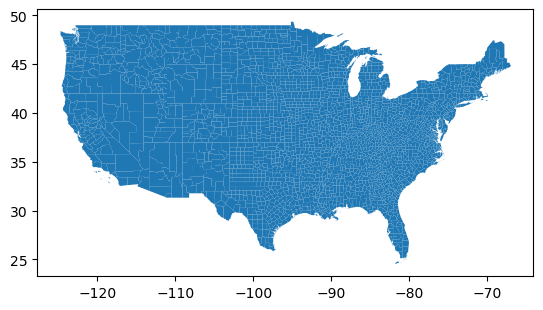

In [5]:
# Plot US county data
us_counties.plot()
plt.show()

In [6]:
# Import vaccination csv data from CDC

vaccines = pd.read_csv('vaccinations.csv')
vaccines.head()

/var/folders/6g/f89nhgmx0fndy3c8kjgy8rhr0000gn/T/ipykernel_17725/2613887108.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  vaccines = pd.read_csv('vaccinations.csv')


,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,...,Census2019_18PlusPop,Census2019_65PlusPop,Bivalent_Booster_5Plus,Bivalent_Booster_5Plus_Pop_Pct,Bivalent_Booster_12Plus,Bivalent_Booster_12Plus_Pop_Pct,Bivalent_Booster_18Plus,Bivalent_Booster_18Plus_Pop_Pct,Bivalent_Booster_65Plus,Bivalent_Booster_65Plus_Pop_Pct
0,05/10/2023,55129,19,Washburn County,WI,96.7,11123.0,70.8,11097.0,73.9,...,12758.0,4304.0,3978.0,26.5,3955.0,28.6,3899.0,30.6,2588.0,60.1
1,05/10/2023,19173,19,Taylor County,IA,97.3,3149.0,51.4,3145.0,55.0,...,4687.0,1392.0,841.0,14.7,841.0,16.3,834.0,17.8,588.0,42.2
2,05/10/2023,36059,19,Nassau County,NY,97.5,1391226.0,95.0,1384503.0,95.0,...,1065968.0,246690.0,236202.0,18.4,231748.0,19.8,224931.0,21.1,109947.0,44.6
3,05/10/2023,48281,19,Lampasas County,TX,98.9,11678.0,54.5,11660.0,57.4,...,16799.0,4322.0,1951.0,9.6,1947.0,10.5,1925.0,11.5,1229.0,28.4
4,05/10/2023,26145,19,Saginaw County,MI,94.0,104075.0,54.6,NaN,NaN,...,149676.0,37414.0,15618.0,8.7,15448.0,9.4,15112.0,10.1,7921.0,21.2


In [7]:
# Import covid cases and mortality data from CDC

covid_cases = gpd.read_file('covid_cases.csv')
deaths = pd.read_csv('covid_deaths.csv')

## Data Cleaning

In [8]:
# Convert FIPS code to string in mortality data
# Drop FIPS codes out of the contiguous 48 states
# Repeat for vaccination data

deaths['FIPS']=deaths['FIPS'].astype(str)
deaths['STFIPS']=deaths['STFIPS'].astype(str)
deaths['COFIPS']=deaths['COFIPS'].astype(str)
fips_to_drop = ["02", "15", "60", "66", "69", "72", "78"]
deaths = deaths[~deaths['STFIPS'].isin(fips_to_drop)]
vaccines['FIPS'] = vaccines['FIPS'].astype(str)
vaccines = vaccines[~vaccines['FIPS'].str.startswith(('02', '15', '72'))]

# Create column in US counties with Fips code by combining state and county FIPS
us_counties['Fips'] = us_counties['STATEFP'].astype(str).str.zfill(2) + us_counties['COUNTYFP'].astype(str).str.zfill(3)


In [12]:
# Clean vaccination data such that only the county name is displayed
# Repeat for covid cases and mortality data

vaccines["Recip_County"] = vaccines["Recip_County"].str.replace(" county", "", case=False, regex=True)
covid_cases["county"] = covid_cases["county"].str.replace(" county", "", case=False, regex=True)
deaths["County"] = deaths["County"].str.replace(" county", "", case=False, regex=True)
poverty['County'] = poverty["County"].str.replace(r" county.*", "", case=False, regex=True)

In [13]:
# Create datetime field in each table

covid_cases["Datetime"] = pd.to_datetime(covid_cases["date_updated"])
vaccines["Datetime"] = pd.to_datetime(vaccines["Date"])
deaths['Datetime']=pd.to_datetime(deaths["Date"])

/var/folders/6g/f89nhgmx0fndy3c8kjgy8rhr0000gn/T/ipykernel_17725/1405038116.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  deaths['Datetime']=pd.to_datetime(deaths["Date"])


In [14]:
# Define two target dates (January 1, 2023 and January 1, 2022)
# Calculate the absolute difference between the current and the target date for vaccination and mortality rates
# Create difference column in data frame 

target_2023 = pd.to_datetime("2023-01-01")
target_2022 = pd.to_datetime("2022-01-01")

covid_cases['diff_2023'] = (covid_cases['Datetime'] - target_2023).abs()
vaccines['diff_2023'] = (vaccines['Datetime'] - target_2023).abs()
deaths['diff_2023'] = (deaths['Datetime'] - target_2023).abs()

covid_cases['diff_2022']=(covid_cases['Datetime'] - target_2022).abs()
vaccines['diff_2022'] = (vaccines['Datetime'] - target_2022).abs()
deaths['diff_2022'] = (deaths['Datetime'] - target_2022).abs()

In [15]:
# Find mortality rates for 2022 and 2023
# Define the start and end of the one-year period
# Filter rows in the specified range
# Fill NA values with zeros
# Group by FIPS code and calculate the sum of the covid deaths in 2023
# Repeat process for 2022

start_date_2023 = target_2023 - pd.Timedelta(days=365)
deaths_2023 = deaths[(deaths['Datetime'] >= start_date_2023) & 
                                 (deaths['Datetime'] < target_2023)]
deaths_2023['Covid_Deaths'] = deaths_2023['Covid_Deaths'].fillna(0)

covid_deaths_2023 = deaths_2023.groupby(['FIPS','County'])[['Covid_Deaths','Total_Deaths']].sum().reset_index()

start_date_2022 = target_2022 - pd.Timedelta(days=365)
deaths_2022 = deaths[(deaths['Datetime'] >= start_date_2022) & 
                                 (deaths['Datetime'] < target_2022)]
deaths_2022['Covid_Deaths'] = deaths_2022['Covid_Deaths'].fillna(0)
covid_deaths_2022 = deaths_2022.groupby(['FIPS','County'])[['Covid_Deaths','Total_Deaths']].sum().reset_index()

/var/folders/6g/f89nhgmx0fndy3c8kjgy8rhr0000gn/T/ipykernel_17725/2737653992.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deaths_2023['Covid_Deaths'] = deaths_2023['Covid_Deaths'].fillna(0)
/var/folders/6g/f89nhgmx0fndy3c8kjgy8rhr0000gn/T/ipykernel_17725/2737653992.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deaths_2022['Covid_Deaths'] = deaths_2022['Covid_Deaths'].fillna(0)


In [16]:
# Group vaccination data by FIPS code and return index of first occurrence of minimum difference
# Perform for 2023 and 2022
# Repeat for covid cases and deaths data

vaccines_grouped_2023 = vaccines.groupby("FIPS")['diff_2023'].idxmin()
vaccines_2023 = vaccines.loc[vaccines_grouped_2023]

vaccines_grouped_2022 = vaccines.groupby("FIPS")['diff_2022'].idxmin()
vaccines_2022 = vaccines.loc[vaccines_grouped_2022]

covid_grouped_2023 = covid_cases.groupby("county_fips")['diff_2023'].idxmin()
covid_2023 = covid_cases.loc[covid_grouped_2023]

covid_grouped_2022 = covid_cases.groupby("county_fips")['diff_2022'].idxmin()
covid_2022 = covid_cases.loc[covid_grouped_2022]

deaths_grouped_2023 = deaths.groupby("County")['diff_2023'].idxmin()
deaths_2023 = deaths.loc[deaths_grouped_2023]

deaths_grouped_2022 = deaths.groupby("County")['diff_2022'].idxmin()
deaths_2022 = deaths.loc[deaths_grouped_2022]

In [17]:
us_counties['Fips'] = us_counties['Fips'].astype(str).str.zfill(5)
covid_deaths_2023['FIPS'] = covid_deaths_2023['FIPS'].astype(str).str.zfill(5)
covid_deaths_2022['FIPS'] = covid_deaths_2022['FIPS'].astype(str).str.zfill(5)

In [18]:
# Join vaccination data with us counties shapefile by Fips Code
# Fill NA values with zeros

vaccinations_2023 = us_counties.merge(vaccines_2023, left_on='Fips',right_on='FIPS')
vaccinations_2023 = gpd.GeoDataFrame(vaccinations_2023,columns=['Date','FIPS','Recip_County','geometry','Administered_Dose1_Recip',
                                           'Administered_Dose1_Pop_Pct','Booster_Doses_Vax_Pct','Recip_State','Administered_Dose1_Recip_65PlusPop_Pct'])
vaccinations_2023 = vaccinations_2023.fillna(0)

vaccinations_2022 = us_counties.merge(vaccines_2022, left_on='Fips',right_on='FIPS')
vaccinations_2022 = gpd.GeoDataFrame(vaccinations_2022,columns=['Date','FIPS','Recip_County','geometry','Administered_Dose1_Recip',
                                           'Administered_Dose1_Pop_Pct','Booster_Doses_Vax_Pct','Recip_State','Administered_Dose1_Recip_65PlusPop_Pct'])
vaccinations_2022 = vaccinations_2022.fillna(0)

In [19]:
# Convert 'Fips' columns in both DataFrames to string
# Join mortality rate data with us county shapefile by Fips Code
# Repeat for 2022 and 2023

us_counties['Fips'] = us_counties['Fips'].astype(str)
covid_deaths_2023['FIPS'] = covid_deaths_2023['FIPS'].astype(str)
covid_deaths_2022['FIPS'] = covid_deaths_2022['FIPS'].astype(str)

us_deaths_2023 = us_counties.merge(covid_deaths_2023, left_on='Fips', right_on='FIPS')
us_deaths_2023 = gpd.GeoDataFrame(us_deaths_2023, columns=['Datetime', 'County', 'FIPS', 'Covid_Deaths', 'Total_Deaths','geometry'])
us_deaths_2023 = us_deaths_2023.fillna(0)

us_deaths_2022 = us_counties.merge(covid_deaths_2022, left_on='Fips', right_on='FIPS')
us_deaths_2022 = gpd.GeoDataFrame(us_deaths_2022, columns=['Datetime', 'County', 'FIPS', 'Covid_Deaths', 'Total_Deaths','geometry'])
us_deaths_2022 = us_deaths_2022.fillna(0)

In [20]:
# Join covid cases data with us county shapefile by Fips code

covid_2022 = covid_2022.drop(columns=['geometry'])
covid_2023 = covid_2023.drop(columns=['geometry'])

covid_cases_2023 = us_counties.merge(covid_2023, left_on='Fips',right_on='county_fips')
covid_cases_2023= gpd.GeoDataFrame(covid_cases_2023,columns=['date_updated','county_fips','SQ_MILES','county','covid_cases_per_100k',
                                                  'health_service_area_population','covid_inpatient_bed_utilization','county_population',
                                                  'covid-19_community_level','geometry'])
covid_cases_2022 = us_counties.merge(covid_2022, left_on='Fips',right_on='county_fips')
covid_cases_2022 = gpd.GeoDataFrame(covid_cases_2022,columns=['date_updated','county_fips','SQ_MILES','county','covid_cases_per_100k',
                                                  'health_service_area_population','covid_inpatient_bed_utilization','county_population',
                                                  'covid-19_community_level','geometry'])

In [21]:
# Repeat workflow for RUCA codes and poverty rate data

ruca['FIPS_Code'] = ruca['FIPS_Code'].astype(str)
poverty['FIPS'] = poverty['FIPS'].astype(str)

us_counties['Fips'] = us_counties['Fips'].str.zfill(5)
ruca['FIPS_Code'] = ruca['FIPS_Code'].str.zfill(5)
poverty['FIPS'] = poverty['FIPS'].str.zfill(5)


us_ruca = us_counties.merge(ruca, left_on='Fips',right_on='FIPS_Code')
us_ruca = gpd.GeoDataFrame(us_ruca,columns=['County','most_common_RUCA','FIPS_Code','geometry'])

us_poverty = us_counties.merge(poverty, left_on='Fips',right_on='FIPS')
us_poverty = gpd.GeoDataFrame(us_poverty,columns=['County','FIPS','Value (Percent)','geometry'])


In [23]:
# Join mortality rates data to covid cases data table

covid_cases_2023 = covid_cases_2023.drop(columns=['geometry'])
covid_cases_2022 = covid_cases_2022.drop(columns=['geometry'])

death_2023 = us_deaths_2023.merge(covid_cases_2023,left_on='FIPS',right_on='county_fips')
death_2023 = gpd.GeoDataFrame(death_2023,columns=['County','FIPS','Covid_Deaths','county_population','geometry'])
death_2022 = us_deaths_2022.merge(covid_cases_2022,left_on='FIPS',right_on='county_fips')
death_2022 = gpd.GeoDataFrame(death_2022,columns=['County','FIPS','Covid_Deaths','county_population','geometry'])

In [24]:
# Convert covid cases per 100k field from string to numeric

covid_cases_2022['covid_cases_per_100k'] = pd.to_numeric(covid_cases_2022['covid_cases_per_100k'], errors='coerce')
covid_cases_2023['covid_cases_per_100k'] = pd.to_numeric(covid_cases_2023['covid_cases_per_100k'], errors='coerce')

In [25]:
# In Covid cases and deaths table, create "Mortality" column by dividing covid deaths by county population and multiplying by 100

death_2023.county_population = death_2023.county_population.astype('float64')
death_2023['Mortality']=death_2023['Covid_Deaths']/death_2023['county_population']*100

death_2022.county_population = death_2022.county_population.astype('float64')
death_2022['Mortality']=death_2022['Covid_Deaths']/death_2022['county_population']*100
death_2023.head()

,County,FIPS,Covid_Deaths,county_population,geometry,Mortality
0,Ballard,21007,0.0,7888.0,"POLYGON ((-89.18137 37.04630, -89.17938 37.053...",0.0
1,Bourbon,21017,0.0,19788.0,"POLYGON ((-84.44266 38.28324, -84.44114 38.283...",0.0
2,Butler,21031,0.0,12879.0,"POLYGON ((-86.94486 37.07341, -86.94346 37.074...",0.0
3,Estill,21065,0.0,14106.0,"POLYGON ((-84.12662 37.64540, -84.12483 37.646...",0.0
4,Fleming,21069,0.0,14581.0,"POLYGON ((-83.98428 38.44549, -83.98246 38.450...",0.0


## Data Visualization

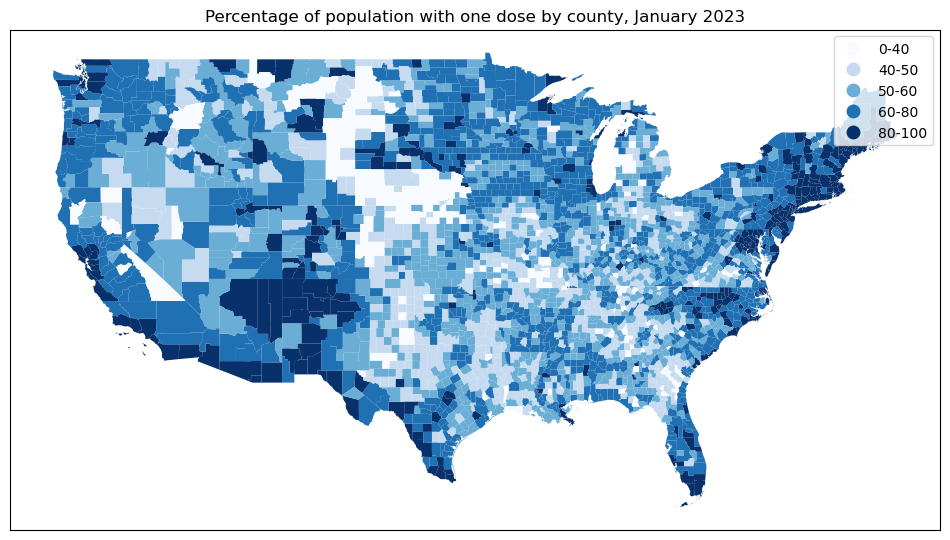

In [26]:
# Plot vaccination rate in January 2023 using percentage of population with first dose

bins = [-1000, 40, 50,60,80,100]  
labels = ['0-40', '40-50', '50-60','60-80','80-100']
vaccinations_2023['Bins']=pd.cut(vaccinations_2023['Administered_Dose1_Pop_Pct'], bins=bins,labels=labels)
vaccinations_2023.plot(column='Bins',cmap='Blues',legend=True,k=5,figsize=(12, 8))
plt.title('Percentage of population with one dose by county, January 2023')
plt.xticks([])
plt.yticks([])
plt.show()

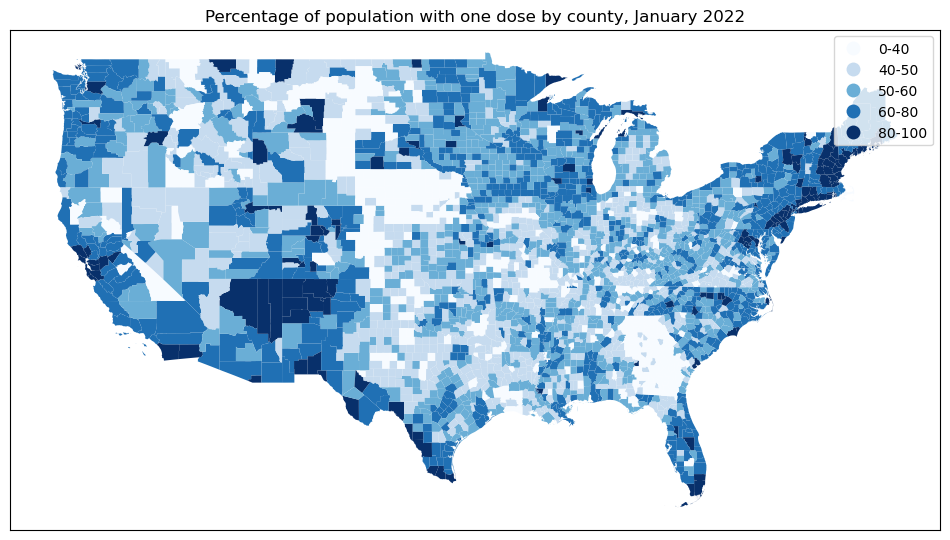

In [27]:
# Plot vaccination rate in January 2022

bins = [-1000, 40, 50,60,80,100] 
labels = ['0-40', '40-50', '50-60','60-80','80-100']
vaccinations_2022['Bins']=pd.cut(vaccinations_2022['Administered_Dose1_Pop_Pct'], bins=bins,labels=labels)
vaccinations_2022.plot(column='Bins',cmap='Blues',legend=True,k=5,figsize=(12, 8))
plt.title('Percentage of population with one dose by county, January 2022')
plt.xticks([])
plt.yticks([])
plt.show()

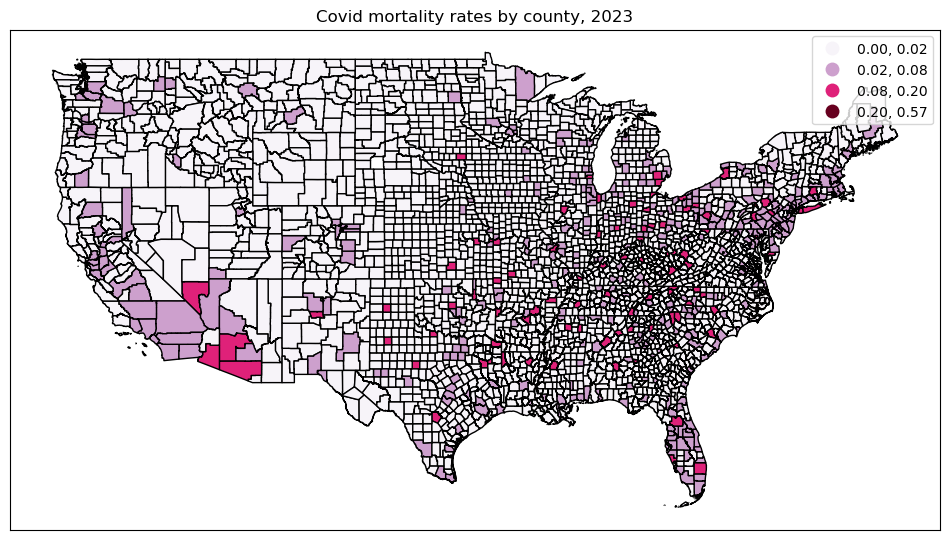

In [28]:
# Plot mortality rate in 2023 per county

death_2023['Bins']=pd.cut(death_2023['Mortality'], bins=bins)
death_2023.plot(column='Mortality',cmap='PuRd',legend=True,edgecolor='black',scheme='naturalbreaks',k=4,figsize=(12, 8))
plt.title('Covid mortality rates by county, 2023')
plt.xticks([])
plt.yticks([])
plt.show()


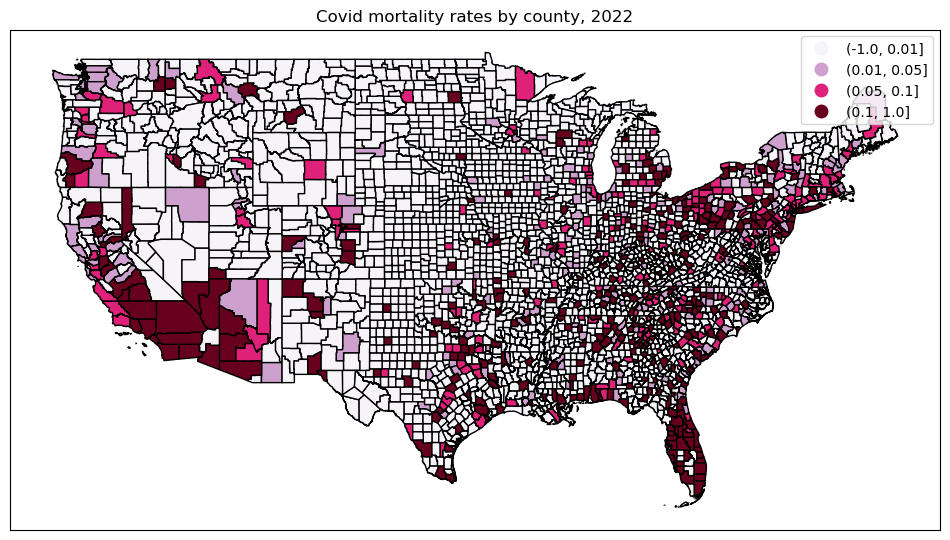

In [29]:
# Plot mortality rate in 2022 per county

bins = [-1,0.01,0.05,0.1,1]
death_2022['Bins']=pd.cut(death_2022['Mortality'], bins=bins)
death_2022.plot(column='Bins',cmap='PuRd',legend=True,edgecolor='black',k=4,figsize=(12, 8))
plt.title('Covid mortality rates by county, 2022')
plt.xticks([])
plt.yticks([])
plt.show()

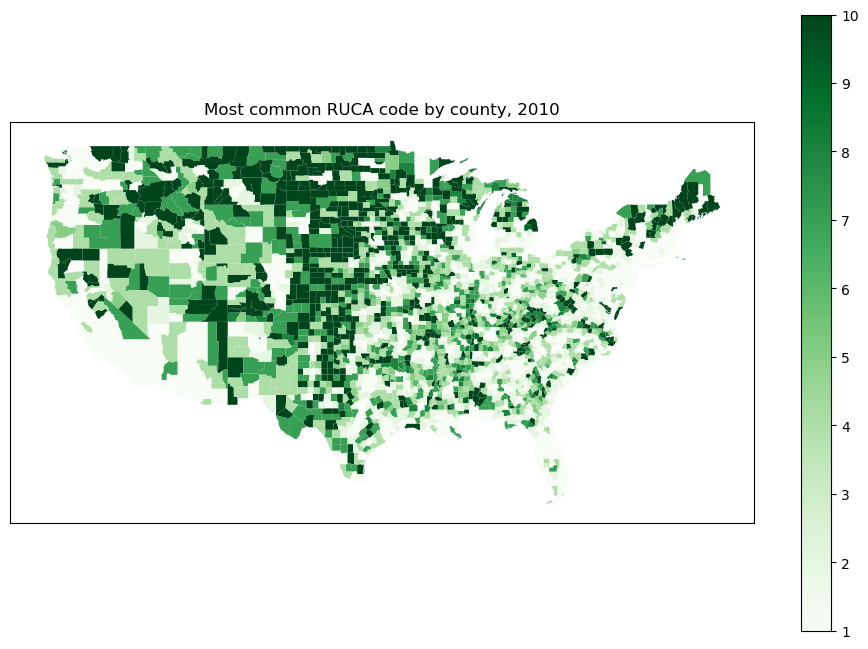

In [30]:
# Plot most common RUCA code by county

us_ruca.plot(column='most_common_RUCA',cmap='Greens',legend=True,k=4,figsize=(12, 8))
plt.title('Most common RUCA code by county, 2010')
plt.xticks([])
plt.yticks([])
plt.show()

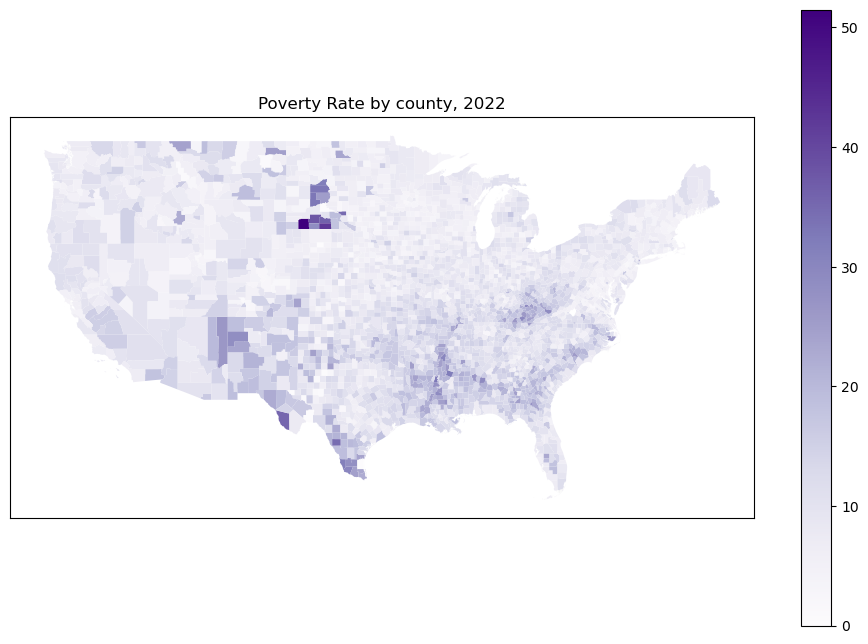

In [31]:
# Plot poverty rate by county

us_poverty.plot(column='Value (Percent)',cmap='Purples',legend=True,k=4,figsize=(12, 8))
plt.title('Poverty Rate by county, 2022')
plt.xticks([])
plt.yticks([])
plt.show()

## Data Cleaning for Regression Analyses

In [32]:
# Drop geometry columns

us_ruca = us_ruca.drop(columns='geometry')
us_poverty = us_poverty.drop(columns='geometry')
us_deaths_2023 = us_deaths_2023.drop(columns='geometry')
us_deaths_2022 = us_deaths_2022.drop(columns='geometry')
vaccinations_2023 = vaccinations_2023.drop(columns='geometry')
vaccinations_2022 = vaccinations_2022.drop(columns='geometry')

In [33]:
# Join all layers (Mortality, vaccinations, us counties layer, Poverty rates, RUCA code) together for the 2023 data
# Repeat for 2022 data

merged_2023 = us_counties.merge(us_ruca,left_on='Fips',right_on='FIPS_Code').merge(us_deaths_2023,left_on='Fips',right_on='FIPS').merge(vaccinations_2023,left_on='Fips',right_on='FIPS').merge(us_poverty,left_on='Fips',right_on='FIPS').merge(covid_cases_2023,left_on='Fips',right_on='county_fips')
merged_2022 = us_counties.merge(us_ruca,left_on='Fips',right_on='FIPS_Code').merge(us_deaths_2022,left_on='Fips',right_on='FIPS').merge(vaccinations_2022,left_on='Fips',right_on='FIPS').merge(us_poverty,left_on='Fips',right_on='FIPS').merge(covid_cases_2022,left_on='Fips',right_on='county_fips')

In [34]:
# Select necessary variables for regression using joined 2023 data
# Create field for percentage of population without vaccine
# Create field for mortality rate per county population

reg_selection = gpd.GeoDataFrame(merged_2023,columns=['most_common_RUCA','Administered_Dose1_Pop_Pct','Value (Percent)','covid_cases_per_100k','Covid_Deaths','Total_Deaths','county_population'])
reg_selection['Percent_without_vaccine']=(1-reg_selection['Administered_Dose1_Pop_Pct']/100)*100
reg_selection['Poverty_Rate']=reg_selection['Value (Percent)']
reg_selection = gpd.GeoDataFrame(reg_selection,columns=['most_common_RUCA','Percent_without_vaccine','Poverty_Rate','covid_cases_per_100k','Covid_Deaths','Total_Deaths','county_population'])
reg_selection['county_population'] = reg_selection['county_population'].astype('int64')
reg_selection['Mortality rate']=reg_selection['Covid_Deaths']/reg_selection['county_population']*100

In [35]:
# Repeat above steps for 2022 data

reg_selection_2022 = gpd.GeoDataFrame(merged_2022,columns=['most_common_RUCA','Administered_Dose1_Pop_Pct','Value (Percent)','covid_cases_per_100k','Covid_Deaths','Total_Deaths','county_population'])
reg_selection_2022['Percent_without_vaccine']=(1-reg_selection_2022['Administered_Dose1_Pop_Pct']/100)*100
reg_selection_2022['Poverty_Rate']=reg_selection_2022['Value (Percent)']
reg_selection_2022 = gpd.GeoDataFrame(reg_selection_2022,columns=['most_common_RUCA','Percent_without_vaccine','Poverty_Rate','covid_cases_per_100k','Covid_Deaths','Total_Deaths','county_population'])
reg_selection_2022['county_population'] = reg_selection_2022['county_population'].astype('int64')
reg_selection_2022['Mortality rate']=reg_selection_2022['Covid_Deaths']/reg_selection_2022['county_population']*100

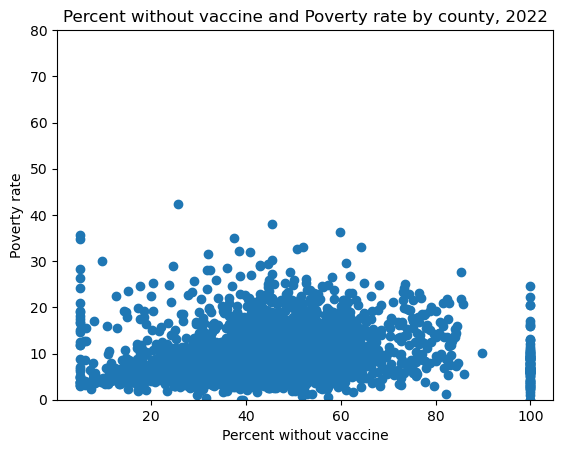

In [36]:
# Plot the relationship between the percent without vaccine and mortality rates in 2022

plt.scatter(reg_selection_2022['Percent_without_vaccine'],reg_selection_2022['Poverty_Rate'])
plt.title('Percent without vaccine and Poverty rate by county, 2022')
plt.xlabel('Percent without vaccine')
plt.ylabel('Poverty rate')
plt.ylim(0,80)
plt.show()

## Regression Analyses

In [37]:
# Split data into X and y training and testing data
# This code is changeable for different variables

from sklearn.model_selection import train_test_split
X=reg_selection.drop(columns=['Covid_Deaths','Mortality rate','Total_Deaths','county_population','covid_cases_per_100k','most_common_RUCA','Percent_without_vaccine'])
y=reg_selection['Mortality rate']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [38]:
# Perform Linear Regression and calculate the r squared value

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()
w=model.fit(X_train,y_train)
y_pred = w.predict(X_test)
r2 = r2_score(y_test,y_pred)
r2

-0.0015440862883107087

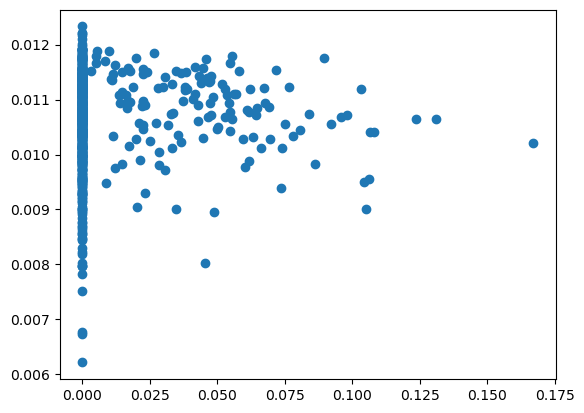

In [39]:
# Visualize relationship between predictions and true values

plt.scatter(y_test,y_pred)

In [40]:
# Perform train test split on 2022 data

X=reg_selection_2022.drop(columns=['Covid_Deaths','Mortality rate','Total_Deaths','county_population','covid_cases_per_100k','most_common_RUCA','Percent_without_vaccine'])
y=reg_selection_2022['Mortality rate']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [41]:
# Perform Linear Regression on 2022 data

model = LinearRegression()
w=model.fit(X_train,y_train)
y_pred = w.predict(X_test)
r2 = r2_score(y_test,y_pred)
r2

-0.000854962531590564

In [42]:
# Perform Logistic Regression
# Display confusion matrix and calculate classification accuracy

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
reg_2022_copy = reg_selection_2022
reg_2022_copy['high_deaths'] = reg_2022_copy['Mortality rate'] > 0.001
X=reg_2022_copy.drop(columns=['Total_Deaths','Covid_Deaths','covid_cases_per_100k','high_deaths','most_common_RUCA','Poverty_Rate','county_population'])
y = reg_2022_copy['high_deaths']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=5)
model = LogisticRegression()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
print(accuracy)

[[923   8]
 [140 172]]
0.8809332260659695
